# PASSO 01 - TRATAMENTO DA BASE DE ACORDO COM O ROTEIRO

## 1.1. imports:

In [2]:
# bibliotecas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import missingno as msno

In [3]:
# dataset:

df = pd.read_csv('cs_bisnode_panel.csv')

## 1.2. Tratamentos iniciais

In [4]:
df1 = df.copy()

# removendo colunas 'COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D':
df1 = df1.drop(['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'], axis=1)

# removendo dados do ano de 2016 da coluna year:
df1 = df1[df1['year']!=2016]

## 1.3. Tratar os missing values de sales 
- Critério: Retirar empresas que possuam ao menos 1 missing value nos anos de 2012, 2013 ou 2014
- Escolhemos estes anos uma vez que:
- 2012 - Será o ano de todos os dados após a criação da variável resposta
- 2013 e 2014 - Serão utilizados para criação da variável resposta

#### 1.3.1. Fazendo lista de comp_id_missing

In [5]:
# uma lista com todos os comp_ids unicos
comp_ids = df1['comp_id'].unique()
comp_ids.size

# lista com os comp_ids que na coluna sales possuem missing values nos anos de 2012, 2013 ou 2014:
comp_ids_missing_2012_2013_2014 = df1[(df1['sales'].isnull()) & ((df1['year'] == 2012) | (df1['year'] == 2013) | (df1['year'] == 2014))]['comp_id'].unique()
comp_ids_missing_2012_2013_2014.size


1429

#### 1.3.2. Remover de df1 os comp_id que possuam missing values em sales e coloca-los no df2

In [8]:
# retirar todos os comp_ids_missing do df1 e insireir no df2 os dados restantes
df2 = df1[~df1['comp_id'].isin(comp_ids_missing_2012_2013_2014)]

# Verifica através de uma contagem de sales com missing values nos anos de 2012, 2013 ou 2014
df2[(df2['sales'].isnull()) & ((df1['year'] == 2012) | (df1['year'] == 2013) | (df1['year'] == 2014))].size


C:\Users\tiago\AppData\Local\Temp\ipykernel_58444\2480200813.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2[(df2['sales'].isnull()) & ((df1['year'] == 2012) | (df1['year'] == 2013) | (df1['year'] == 2014))].size


0

## 1.4. Valores Negativos em Sales
1. Há poucos valores negativos. 
2. Valores negativos podem representar um erro. 
* Logo, substituir esses missing values por zero não tratará prejuízo ao modelo

In [9]:
#verificar o numero de comp_id com valores de sales negativas
df2[df2['sales']<0]['comp_id'].unique().size

#Tranformar as Sales negativas em 0
df2['sales'] = df2['sales'].apply(lambda x: 0 if x < 0 else x)

C:\Users\tiago\AppData\Local\Temp\ipykernel_58444\337595926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sales'] = df2['sales'].apply(lambda x: 0 if x < 0 else x)


## 1.5. Criar variável resposta

Variável "will_close" que indique se a empresa não possui vendas no ano seguinte *E* no próximo, desde que ela apresente venda no ano atual.

*** Fazer condição para verificar se ela volta a ter vendas depois de ter fechado por 2 anos? ***

Opinião Tiago: Não tenho interesse em saber se a empresa abriu após ter fechado, uma vez que o motivo da reabertura pode ser diverso e não temos a informação. O que acham?


In [10]:
# Ordenar por 'comp_id' e 'year' para utilização da função shift:
df2 = df2.sort_values(['comp_id', 'year'])

# Condicionais para verificação de empresas que fecharam:
df2['will_close'] = np.where(
    (df2['sales'] > 0) 
    & 
    (df2.groupby('comp_id')['sales'].shift(-1) <= 0) 
    & 
    (df2.groupby('comp_id')['sales'].shift(-2) <= 0), 1, 0)

# Verificando se a variável foi criada corretamente:
df2[['comp_id', 'year','sales', 'will_close']].head(11).sort_values('comp_id')



,comp_id,year,sales,will_close
0,1001034.0,2005,62751.851562,0
1,1001034.0,2006,64625.925781,0
2,1001034.0,2007,65100.000000,0
3,1001034.0,2008,78085.187500,0
4,1001034.0,2009,45388.890625,0
5,1001034.0,2010,9929.629883,1
6,1001034.0,2011,0.000000,0
7,1001034.0,2012,0.000000,0
8,1001034.0,2013,0.000000,0
9,1001034.0,2014,0.000000,0


## 1.7. Filtrar empresas do ano de 2012

In [11]:
df2 = df2[df2['year']==2012]

## 1.8. tratar valores negativos da coluna sales 
utilizando np.where para trocar valores negativos por 0:


In [12]:
df2['sales'] = np.where(df2['sales']<0, 0, df2['sales'])

## 1.9. criar coluna em log da variável sales:


In [13]:
df2['log_sales'] = np.log(df2['sales'])

c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 1.10. Criação da coluna da idade da empresa 

In [14]:
# Define uma função para preencher NaN com o primeiro valor não NaN, ou NaN se todos forem NaN
def fill_first_non_nan(series):
    non_nan_values = series.dropna()
    return non_nan_values.iloc[0] if not non_nan_values.empty else np.nan

# Preenche os valores NaN na coluna "founded_date" com base na função definida
df2['founded_date'] = df2.groupby('comp_id')['founded_date'].transform(fill_first_non_nan)

# Converte a coluna "founded_date" para o tipo datetime
df2['founded_date'] = pd.to_datetime(df2['founded_date'])

# Calcula a idade com base na coluna "year" e "founded_date"
df2['comp_age'] = df2['year'] - df2['founded_date'].dt.year

## 1.11. Filtro de revenue da empresa e criação da coluna de porte da empresa

In [15]:
# Pega a média de vendas de uma empresa durante os anos determinados
revenue = df2.groupby('comp_id')['sales'].mean()

# Junta a coluna criada no dataframe original
df2 = df2.merge(revenue, how="inner", on="comp_id").rename(columns={"sales_y": "revenue"})

#Condições para definir se a empresa é pequena, média ou grande
conditions = [(df2["revenue"] <= 50000), 
              (df2["revenue"] < 100000) & (df2["revenue"] > 50000),
              (df2["revenue"] >= 100000)]

choices = ["Pequena", "Média", "Grande"]

df2["comp_size"] = np.select(conditions, choices, default=0)

In [16]:
#Filtro para selecionar empresas com revenue maior que 1000 e menor que 10 MM
df2 = df2[(df2["revenue"] > 1000) & (df2["revenue"] < 10000000)]

# retirando empresas que apresentaram sales == 0 da base
* Empresas sem vendas no ano de 2012 não são úteis para verificarmos se a empresa irá fechar em 2 anos ou não


In [17]:
df2 = df2[df2['sales_x'] != 0]

## 1.12. Criação da coluna de capital circulante líquido

*curr_assets* -> Ativos Circulantes

*curr_liab* -> Passivos Circulantes

Com esses dois valores, é possível calcular o **capital circulante líquido**, dividindo os ativos circulantes por passivos circulantes. Esse valor significa o quanto a empresa consegue pagar suas contas e dívidas no prazo correto.

É interessante fazer mais uma coluna com esse cálculo pois pode ser um dos motivos aos quais a empresa fechou.

Ex: Caso uma empresa tenha o valor de liquidez corrente igual a 2, significa que a cada R$ 1,00 de dívida, ela tem R$ 2,00 para abater essa dívida.

Então, empresas com valores menores que 1, significa que elas não conseguem abater a dívida naquele ano.

In [18]:
df2["curr_idx_liq"] = df2["curr_assets"]/df2["curr_liab"]

# PASSO 02 - DESCRICAO DOS DADOS

## 2.1. Dimensão dos dados

In [19]:
print( 'Numero de Linhas: {}'.format( df2.shape[0] ) )
print( 'Número de Colunas: {}'.format( df2.shape[1] ) )

Numero de Linhas: 21635
Número de Colunas: 48


## 2.2. Tipo dos dados


In [20]:
df2.dtypes

comp_id                        float64
begin                           object
end                             object
amort                          float64
curr_assets                    float64
curr_liab                      float64
extra_exp                      float64
extra_inc                      float64
extra_profit_loss              float64
fixed_assets                   float64
inc_bef_tax                    float64
intang_assets                  float64
inventories                    float64
liq_assets                     float64
material_exp                   float64
personnel_exp                  float64
profit_loss_year               float64
sales_x                        float64
share_eq                       float64
subscribed_cap                 float64
tang_assets                    float64
balsheet_flag                    int64
balsheet_length                  int64
balsheet_notfullyear             int64
year                             int64
founded_year             

## 2.3. Mudando Tipo dos Dados

Vamos converter os tipos de dados algumas colunas para que estas esteja coerentes com as descrição das variáveis, a saber:

- comp_id: como é a identificação da empresa, deve ser considerada uma string (object)
- begin: converter para data
- end: converter para data
- founded_date: converter para data
- exit_date: converter para data
- nace_main: converter para string (object)
- ind2: converter para string (object)
- ind: converter para string (object)
- will_close: converter para int64

In [21]:
df2['comp_id'] = df['comp_id'].astype('object')
df2['begin'] = pd.to_datetime(df['begin'],format="%Y-%m-%d", errors='coerce')
df2['end'] = pd.to_datetime(df['end'],format="%Y-%m-%d", errors='coerce')
df2['founded_date'] = pd.to_datetime(df['founded_date'],format="%Y-%m-%d", errors='coerce')
df2['exit_date'] = pd.to_datetime(df['exit_date'],format="%Y-%m-%d", errors='coerce')
df2['nace_main'] = df['nace_main'].astype('object')
df2['ind2'] = df['ind2'].astype('object')
df2['ind'] = df['ind'].astype('object')
df2['will_close'] = df2['will_close'].astype('boolean')

## 2.4. Checando NA

<Axes: >

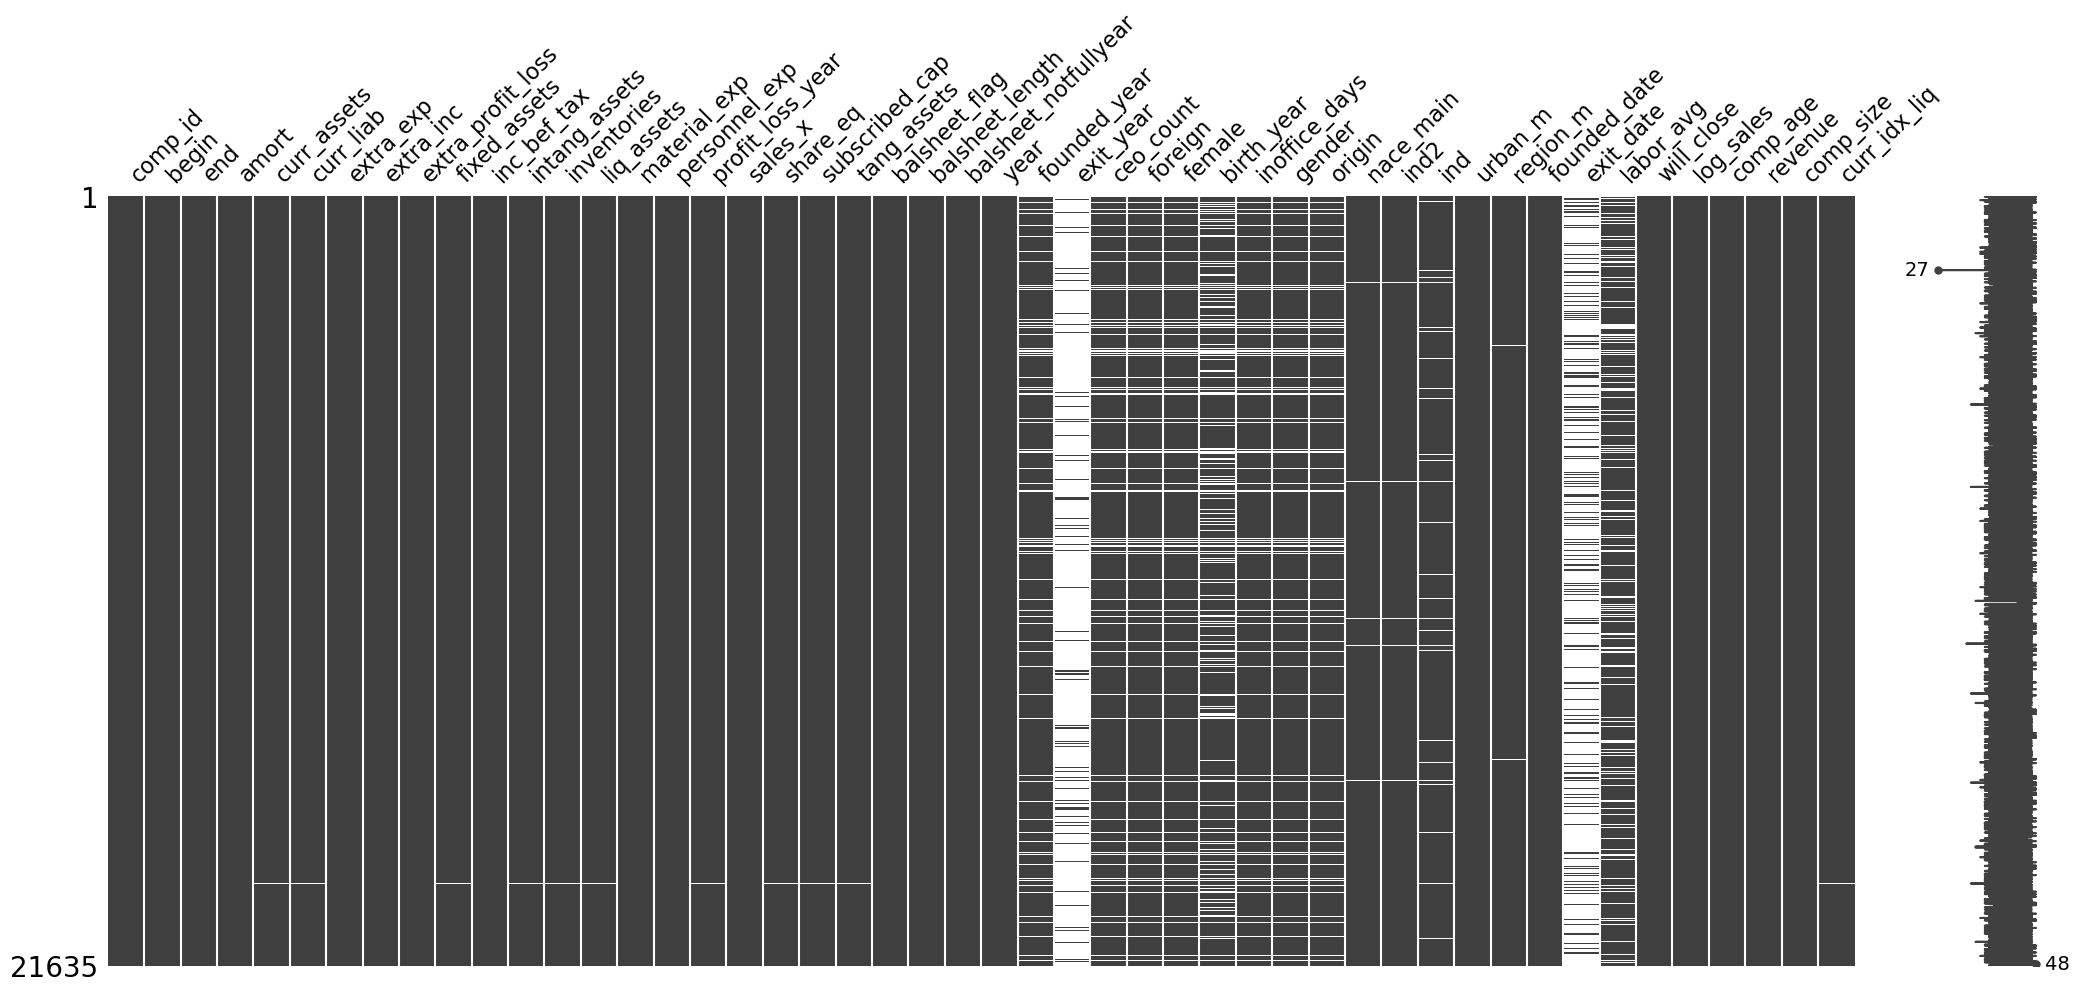

In [22]:
import missingno as msno

msno.matrix(df2)

In [23]:
missing_values = df2.isna().sum()
missing_values = pd.DataFrame({ 'Qtd_Valores_Faltantes': missing_values}).reset_index()
missing_values[missing_values['Qtd_Valores_Faltantes'] > 0]

,index,Qtd_Valores_Faltantes
3,amort,40
4,curr_assets,10
5,curr_liab,10
9,fixed_assets,10
11,intang_assets,10
12,inventories,10
13,liq_assets,10
14,material_exp,40
15,personnel_exp,40
16,profit_loss_year,10


In [24]:
df3 = df2.copy()

## 2.5. Preenchendo NA

In [25]:
# Considerar ZERO os missing values das variáveis "extra_exp", "extra_inc", "extra_profit_loss". 
# Como são gastos de natureza eventual, os missing values podem representar que não houve esse tipo de dado para o ano em questão;

df3['extra_exp'] = df3['extra_exp'].fillna(0)
df3['extra_inc'] = df3['extra_inc'].fillna(0)
df3['extra_profit_loss'] = df3['extra_profit_loss'].fillna(0)

# Subsitutir pela média da empresa as variáveis numéricas: 
# "amort", "curr_assets", "curr_liab", "fixed_assets", "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp", "tang_assets", "labor_avg". 
# São variáveis de natureza contábil e que tem um peso importante para explicar a saúde financeira da empresa. 
# Logo, substituir pela média da empresa mantém a distribuição dos dados intacta e utilizar por ZERO ou excluir os dados pode prejudicar a estimativa do modelo

df3['amort'] = df3['amort'].fillna(df3['amort'].mean())
df3['curr_assets'] = df3['curr_assets'].fillna(df3['curr_assets'].mean())
df3['curr_liab'] = df3['curr_liab'].fillna(df3['curr_liab'].mean())
df3['fixed_assets'] = df3['fixed_assets'].fillna(df3['fixed_assets'].mean())
df3['inc_bef_tax'] = df3['inc_bef_tax'].fillna(df3['inc_bef_tax'].mean())
df3['intang_assets'] = df3['intang_assets'].fillna(df3['intang_assets'].mean())
df3['inventories'] = df3['inventories'].fillna(df3['inventories'].mean())
df3['liq_assets'] = df3['liq_assets'].fillna(df3['liq_assets'].mean())
df3['material_exp'] = df3['material_exp'].fillna(df3['material_exp'].mean())
df3['personnel_exp'] = df3['personnel_exp'].fillna(df3['personnel_exp'].mean())
df3['tang_assets'] = df3['tang_assets'].fillna(df3['tang_assets'].mean())
df3['labor_avg'] = df3['labor_avg'].fillna(df3['labor_avg'].mean())


# Subsitutir pela média da empresa as variáveis: "urban_m", "region_m", "founded_date", 
# São variáveis não numéricas que podem ajudar na construção do modelo, pois podem ter a priori relevância na explicação da variável resposta.

df3['urban_m'] = df3['urban_m'].fillna(df3['urban_m'].mean())
df3['founded_date'] = df3['founded_date'].fillna(df3['founded_date'].mean())

#substituindo region_m pela moda
mode_series = df3['region_m'].mode()
if not mode_series.empty:
    df3['region_m'].fillna(mode_series.iloc[0], inplace=True)

In [27]:
# verificando valores na:
df3.isna().sum()

comp_id                     0
begin                       0
end                         0
amort                       0
curr_assets                 0
curr_liab                   0
extra_exp                   0
extra_inc                   0
extra_profit_loss           0
fixed_assets                0
inc_bef_tax                 0
intang_assets               0
inventories                 0
liq_assets                  0
material_exp                0
personnel_exp               0
profit_loss_year           10
sales_x                     0
share_eq                   10
subscribed_cap             10
tang_assets                 0
balsheet_flag               0
balsheet_length             0
balsheet_notfullyear        0
year                        0
founded_year             2003
exit_year               19559
ceo_count                2001
foreign                  2001
female                   2001
birth_year               4844
inoffice_days            2001
gender                   2001
origin    

## 2.6. Análise Descritiva

In [28]:
var_num = df3.select_dtypes( include=['int64', 'float64'] )
var_cat = df3.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

var_num.columns

Index(['amort', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc',
       'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets',
       'inventories', 'liq_assets', 'material_exp', 'personnel_exp',
       'profit_loss_year', 'sales_x', 'share_eq', 'subscribed_cap',
       'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'exit_year',
       'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days',
       'urban_m', 'labor_avg', 'log_sales', 'comp_age', 'revenue',
       'curr_idx_liq'],
      dtype='object')

### 2.6.1. Atributos Numéricos

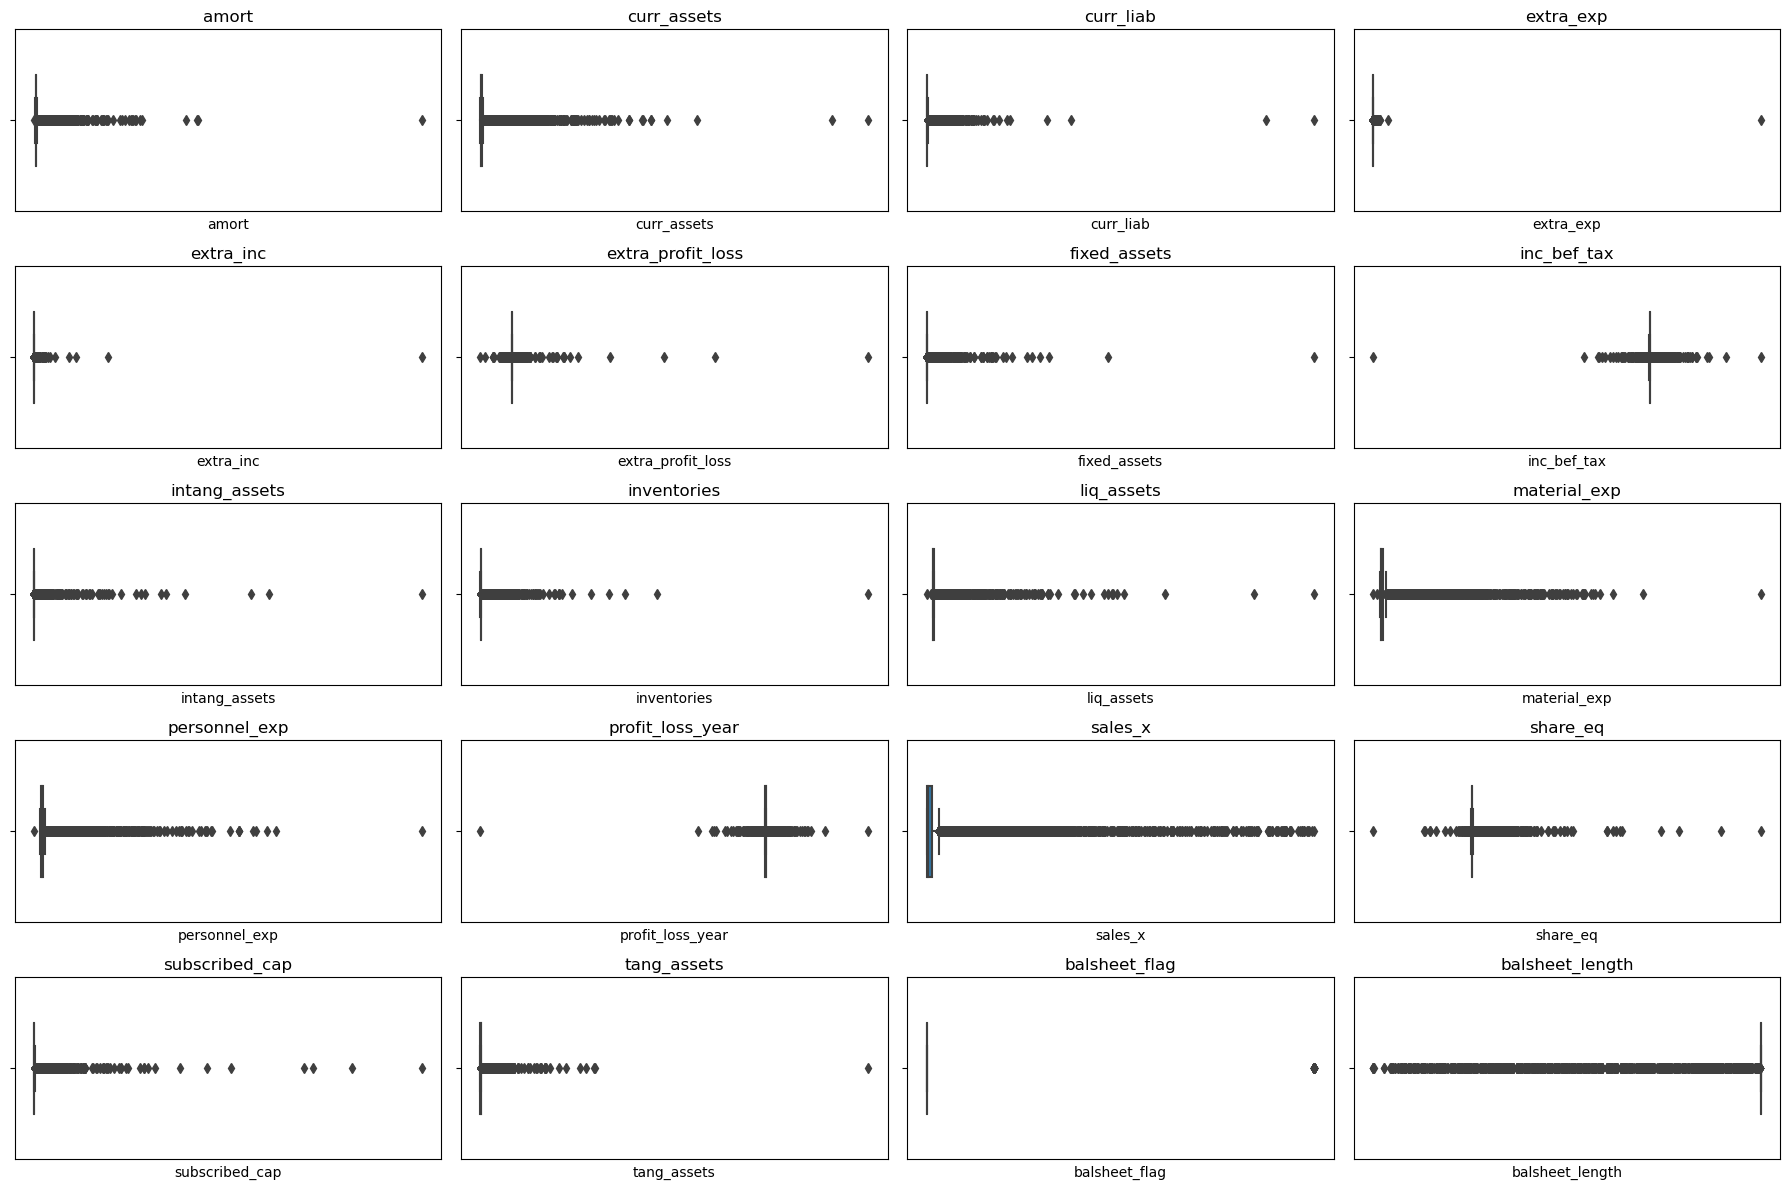

c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


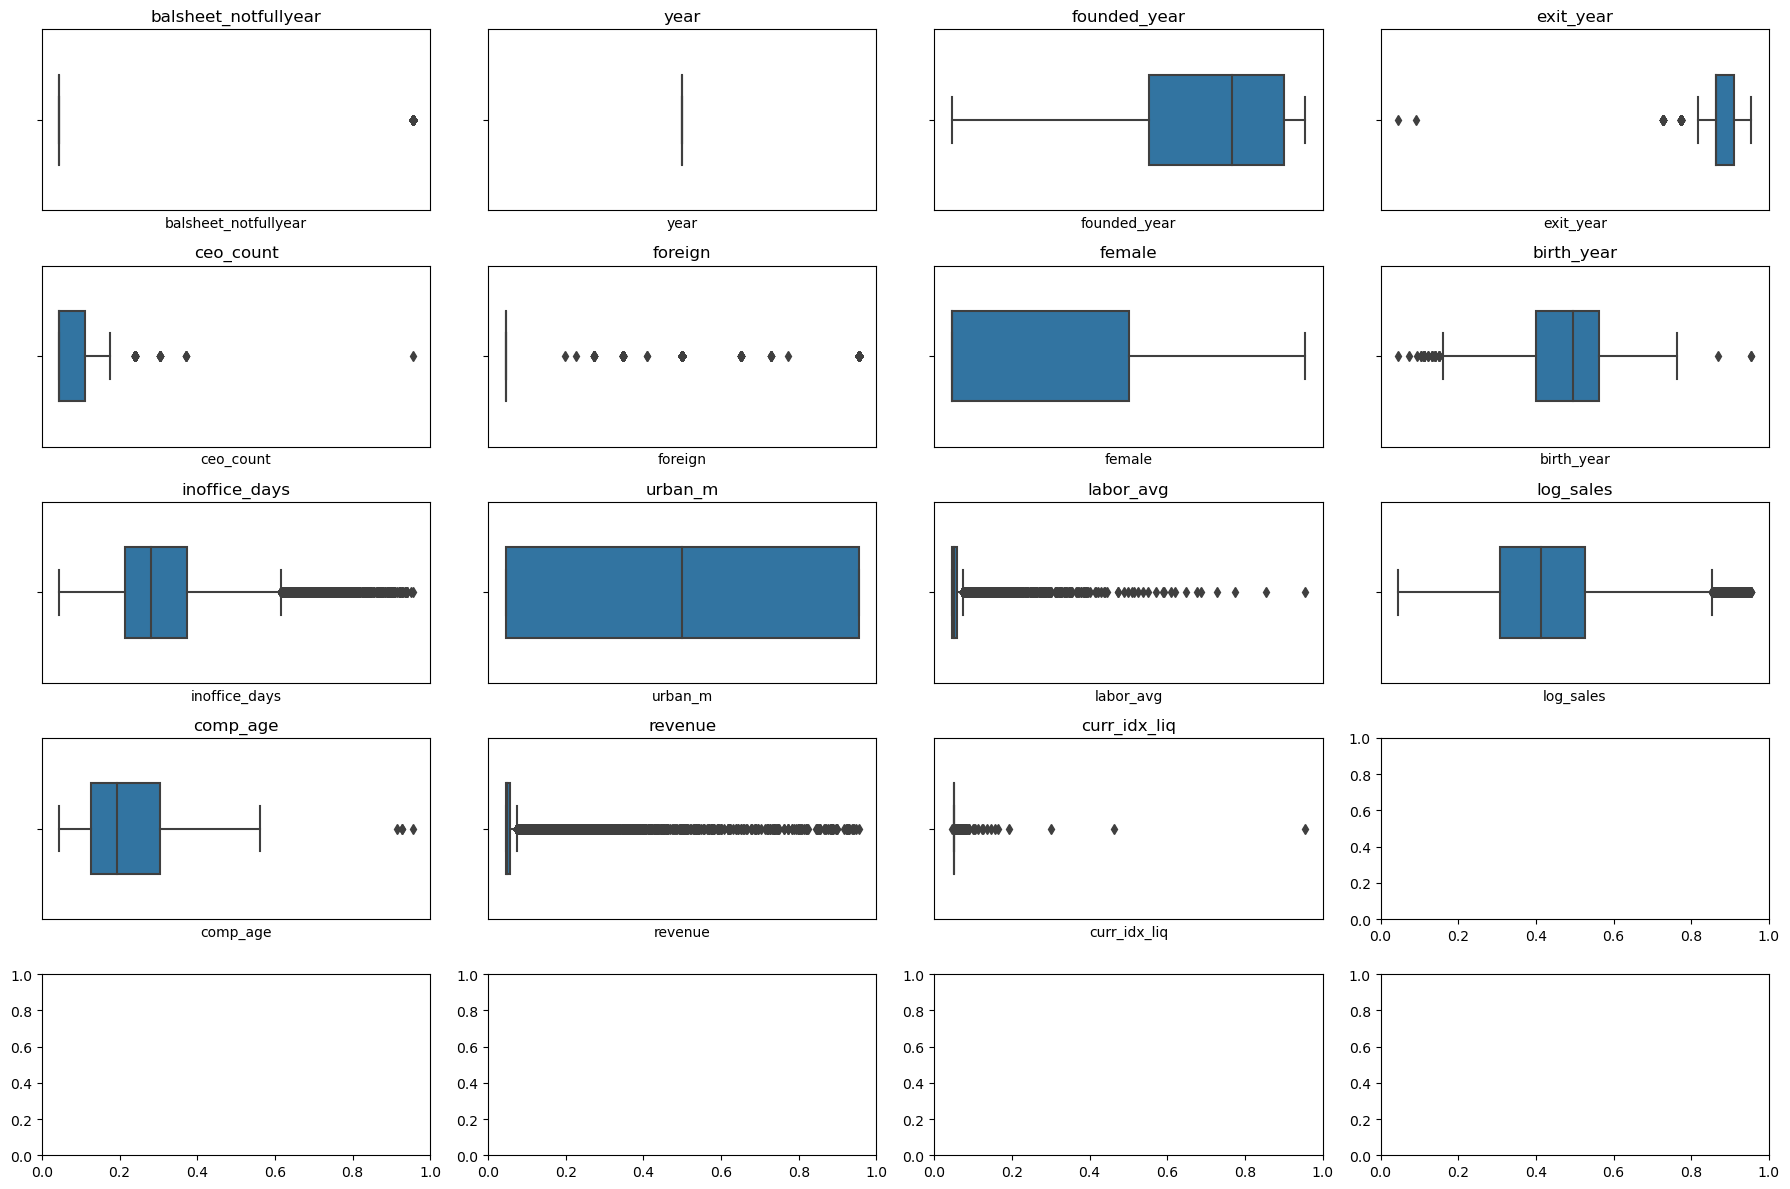

In [30]:
# fazendo boxplot de todas as variáveis numéricas para identificar as distribuições:

colunas = var_num.columns

# Configurações para a disposição dos subplots
num_linhas = 5  
num_colunas = 4  

# Calcula o número total de figuras necessárias
num_total_figuras = (len(colunas) // (num_linhas * num_colunas)) + 1

# Tamanho da figura
tamanho_figura = (18, 12)

# Loop para criar cada figura com os boxplots
for figura_num in range(num_total_figuras):
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=tamanho_figura)
    
    # Colunas para esta figura
    inicio_coluna = figura_num * num_linhas * num_colunas
    fim_coluna = (figura_num + 1) * num_linhas * num_colunas
    colunas_figura = colunas[inicio_coluna:fim_coluna]

    # Iterar pelas colunas e criar os boxplots para esta figura
    for i, coluna in enumerate(colunas_figura):
        linha = i // num_colunas
        col = i % num_colunas
        sns.boxplot(x=var_num[coluna], ax=axs[linha, col], width=0.5)
        axs[linha, col].set_title(coluna)
        axs[linha, col].set_xticks([])  # Remove os rótulos do eixo x

    # Ajustar o layout
    plt.tight_layout()

    # Exibir a figura
    plt.show()

### 2.6.2. Atributos Categóricos

# PASSO 03 - FEATURE ENGINEERING

## 3.1. Criacao das Hipoteses

### 3.1.1. Hipoteses Financeiras

1. Empresas com maior amortização tendem a manter-se abertas.
Justificação: Empresas que amortizam ativos de forma consistente podem estar investindo em atualizações de ativos e infraestrutura, o que pode contribuir para sua estabilidade financeira.

2. Empresas com maiores ativos circulantes (current assets) têm maior probabilidade de permanecer abertas.
Justificação: Um alto nível de ativos circulantes pode indicar uma capacidade maior de lidar com despesas de curto prazo e obrigações, o que é fundamental para a sobrevivência a curto prazo.

3. Empresas com dívidas de curto prazo (current liabilities) menores são mais propensas a permanecer abertas.
Justificação: Empresas com menos dívidas de curto prazo podem enfrentar menos pressão financeira e ter mais flexibilidade para cumprir suas obrigações.

4. Empresas com maiores despesas extras (extra_expenditures) têm maior risco de fechamento.
Justificação: Despesas extras elevadas podem indicar instabilidade financeira ou gastos não planejados, o que pode impactar negativamente a saúde financeira da empresa.

5. Empresas com receitas extras (extra income) mais consistentes têm menor probabilidade de fechar.
Justificação: Receitas extras podem contribuir para a estabilidade financeira, tornando a empresa mais capaz de enfrentar desafios.

6. Empresas com prejuízos extras (extra profit loss) frequentes têm maior probabilidade de fechar.
Justificação: Prejuízos extras podem indicar problemas financeiros contínuos que podem levar ao fechamento.

7. Empresas com maiores vendas domésticas líquidas (net domestic sales) têm menor probabilidade de fechar.
Justificação: Vendas domésticas sólidas podem indicar uma base de clientes estável e uma demanda consistente por produtos ou serviços.

8. Empresas com maiores vendas de exportação líquidas (net export sales) tendem a ser mais resilientes.
Justificação: Vendas de exportação podem diversificar a base de clientes e aumentar a resiliência da empresa a flutuações no mercado doméstico.

9. Empresas com lucros anuais (Profit/loss, annual) consistentemente positivos têm maior probabilidade de permanecer abertas.
Justificação: Lucros consistentes podem indicar uma saúde financeira sólida.

10. Empresas com maiores vendas totais (Total sales) têm menor probabilidade de fechar.
Justificação: Um alto volume de vendas pode fornecer a base financeira necessária para a continuidade das operações.

11. Empresas com maior patrimônio líquido (Shareholder equity) têm maior probabilidade de permanecer abertas.
Justificação: O patrimônio líquido representa a saúde financeira de longo prazo da empresa e pode indicar sua capacidade de enfrentar desafios.

12. Empresas com maior capital subscrito (Subscribed capital) tendem a ser mais estáveis.
Justificação: Um alto capital subscrito pode indicar um nível de investimento e confiança que pode contribuir para a continuidade das operações.

13. Empresas com ativos tangíveis (Tangible assets) mais substanciais têm maior probabilidade de permanecer abertas.
Justificação: Ativos tangíveis, como propriedades e equipamentos, podem fornecer uma base de valor e estabilidade financeira.

14. Empresas com maiores investimentos em Ativos Fixos (Fixed assets) têm maior probabilidade de permanecer abertas.
Justificação: Empresas que alocam recursos significativos para ativos fixos, como propriedades, equipamentos e instalações, estão investindo em sua infraestrutura e capacidade de produção a longo prazo. Isso pode torná-las mais resistentes a flutuações econômicas e mais capazes de atender às demandas de seus clientes, o que, por sua vez, pode aumentar suas chances de permanecerem abertas.

### 3.1.2. Hipoteses de Boarding

1. Empresas com um maior número de CEO/Top Executivos têm maior probabilidade de permanecerem abertas.
Justificação: Uma equipe de liderança robusta e diversificada pode tomar decisões mais eficazes e enfrentar desafios de negócios com mais resiliência, o que pode contribuir para a continuidade da empresa.

2. Empresas com uma maior proporção de CEOs estrangeiros (Share of foreign CEOs) têm maior probabilidade de permanecerem abertas.
Justificação: CEOs estrangeiros podem trazer perspectivas globais e conhecimento diversificado, o que pode ser vantajoso para a empresa em um mercado internacional.

3. Empresas com uma maior proporção de CEOs do sexo feminino (Share of female CEOs) tendem a ser mais estáveis.
Justificação: Diversidade de gênero na liderança pode trazer uma variedade de habilidades e perspectivas, o que pode ser benéfico para a tomada de decisões e a adaptação a diferentes desafios.

4. Empresas com CEOs mais jovens (menor média de ano de nascimento dos CEOs) têm maior probabilidade de permanecerem abertas.
Justificação: CEOs mais jovens podem trazer inovação e uma abordagem fresca aos negócios, o que pode ser vantajoso em mercados dinâmicos.

5. Empresas com CEOs que têm um tempo médio mais longo de permanência no cargo tendem a ser mais estáveis.
Justificação: CEOs que permanecem no cargo por um período mais longo podem estabelecer estratégias a longo prazo e relacionamentos sólidos, o que pode contribuir para a continuidade da empresa.

6. Empresas com uma maior diversidade de gênero no quadro de diretores (board) tendem a ser mais estáveis.
Justificação: A diversidade de gênero no board pode refletir uma cultura de inclusão e diversidade na empresa, o que pode contribuir para a continuidade e resiliência da organização.

7. Empresas com CEOs de diferentes origens geográficas (Origin of CEO) têm maior probabilidade de enfrentar desafios de forma mais eficaz.
Justificação: CEOs com diferentes origens geográficas podem trazer uma variedade de perspectivas culturais e conhecimento global, o que pode ser valioso em um ambiente de negócios cada vez mais internacional.

### 3.1.3. Hipoteses Comporação

1. Empresas fundadas há muito tempo (Firm founded year) tendem a ter maior probabilidade de permanecerem abertas.
Justificação: Empresas com uma história mais longa podem ter construído uma base sólida de clientes e relações comerciais duradouras, o que pode contribuir para sua continuidade.

2. Empresas em setores de indústria mais amplos (broad industry code) são mais resilientes e têm maior probabilidade de se manterem abertas.
Justificação: Setores de indústria amplos podem permitir que as empresas diversifiquem suas operações, o que pode ajudar a atenuar impactos negativos em um segmento específico do mercado.

3. Empresas com uma maior média de funcionários (Number of employees) têm maior probabilidade de permanecerem abertas.
Justificação: Empresas com uma força de trabalho maior podem ter mais recursos e capacidade para enfrentar desafios, além de manter operações consistentes.

4. Empresas localizadas em regiões geográficas economicamente estáveis (Firm HQ region) têm maior probabilidade de se manterem abertas.
Justificação: Estabilidade econômica na região de sede da empresa pode contribuir para um ambiente de negócios previsível e sustentável.

5. Empresas fundadas em datas mais recentes (Firm founded date) são mais adaptáveis e têm maior probabilidade de se manterem abertas, pois podem adotar tecnologias e práticas de negócios modernas.
Justificação: Empresas mais recentes podem ter vantagens em termos de inovação e capacidade de se ajustar rapidamente às mudanças no mercado.

6. O setor de indústria específico em que a empresa atua (NACE industry code, 4 dígitos) influencia diretamente sua continuidade, com algumas indústrias sendo mais resilientes do que outras.
Justificação: Diferentes setores de indústria podem ser afetados de maneira diferente por fatores econômicos e sociais, o que pode impactar a capacidade de uma empresa de permanecer aberta.



### 3.1.4. Hipoteses Tempo

- 1. Empresas com um maior número de anos de operação (year) têm maior probabilidade de permanecerem abertas, pois a longevidade no mercado pode indicar estabilidade e experiência.
Justificação: Empresas com um histórico mais longo podem ter construído relacionamentos duradouros com clientes e parceiros de negócios.

## 3.2. Feature Engineering

### 3.2.1. Criação de colunas

In [31]:
# Capital Circulante Líquido

# Idade da empresa

# Porte da empresa (critério: pequenas < 50 mil e médias e grandes > 50 mil)

# PASSO 04 - FILTRAGEM DE VARIÁVEIS

## 4.1. Filtragem das Linhas

In [32]:
# Sugiro de passarmos os tópicos 1.3 e 1.4 para cá, uma vez que o tópico #1 se trata do passo a passo do roteiro passado pelos professores, e aquela etapa não consta.
# Portanto, vejo sentido em deixar lá somente o passo a passo do roteiro dos professores e, para as demais transformações, organizarmos nos tópicos correspondentes do notebook.

## 4.2. Selecao das Colunas

### 4.2.1. Excluir as colunas 

- variáveis com datas ou anos 'begin', 'end', 'year', 'founded_year', 'exit_year', 'exit_date'. Os modelos a serem aplicados não suportam esse tipo de variável.
- dados sobre o balanço 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear'. Número relevante de missing values.
- Informações sobre os CEO: "ceo_count", "foreign", "female", "birth_year", "inoffice_days", "gender", "origin". Podem causar viés inesperado no modelo, uma vez que não há evidências que essas variáveis influenciam a gestão de uma empresa
- Informações sobre o setor de atuação da empresa: 'nace_main', 'ind2', 'ind'. Como serão utilizados somentes dados somente de 2012 para a construção do modelo, pode-se criar a falsa correlação que uma empresa pode falir por atuar num determinado setor que, por questões exogênas, pode apresentar melhores condições para uma empresa prosperar do que outros. Caso o ambiente econômico de um setor mude em relação ao ano de 2012, isso pode aumentar o erro do modelo.
- As variáveis "curr_assets", "curr_liab", "urban_m", "region_m", "labor_avg" terão a sua relevância para o modelo avaliada durante a fase de modelagem, uma vez que não há certeza sobre o poder de explicação das mesmas.


In [33]:
df3 = df2.drop(['begin', 'end', 'year', 'founded_year', 'exit_year', "ceo_count", "foreign", "female", "birth_year", "inoffice_days", "gender", "origin", 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear','nace_main', 'ind', 'ind2'], axis=1)

# PASSO 05 - ANALISE EXPLORATORIA DOS DADOS

## 5.1. Analise Univariada

In [58]:
var_num = df3.select_dtypes( include=['int64', 'float64'] )
var_cat = df3.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

### 5.1.1. Variável Resposta

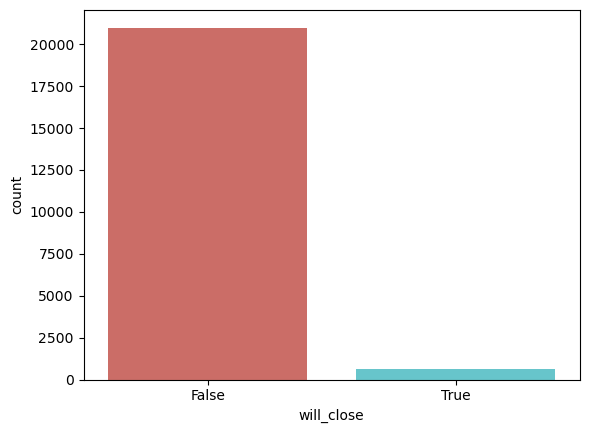

In [59]:
# Fazendo gráfico de barras para a variável "will_close":
sns.countplot(x='will_close', data=df2, palette='hls')
plt.show()


### 5.1.2. Variável Numérica

### 5.1.3. Variável Categórica

## 5.2. Análise Multivariada

C:\Users\tiago\AppData\Local\Temp\ipykernel_58444\1618693627.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df3.corr()[df3.corr() > 0.5], annot=True, cmap='coolwarm')


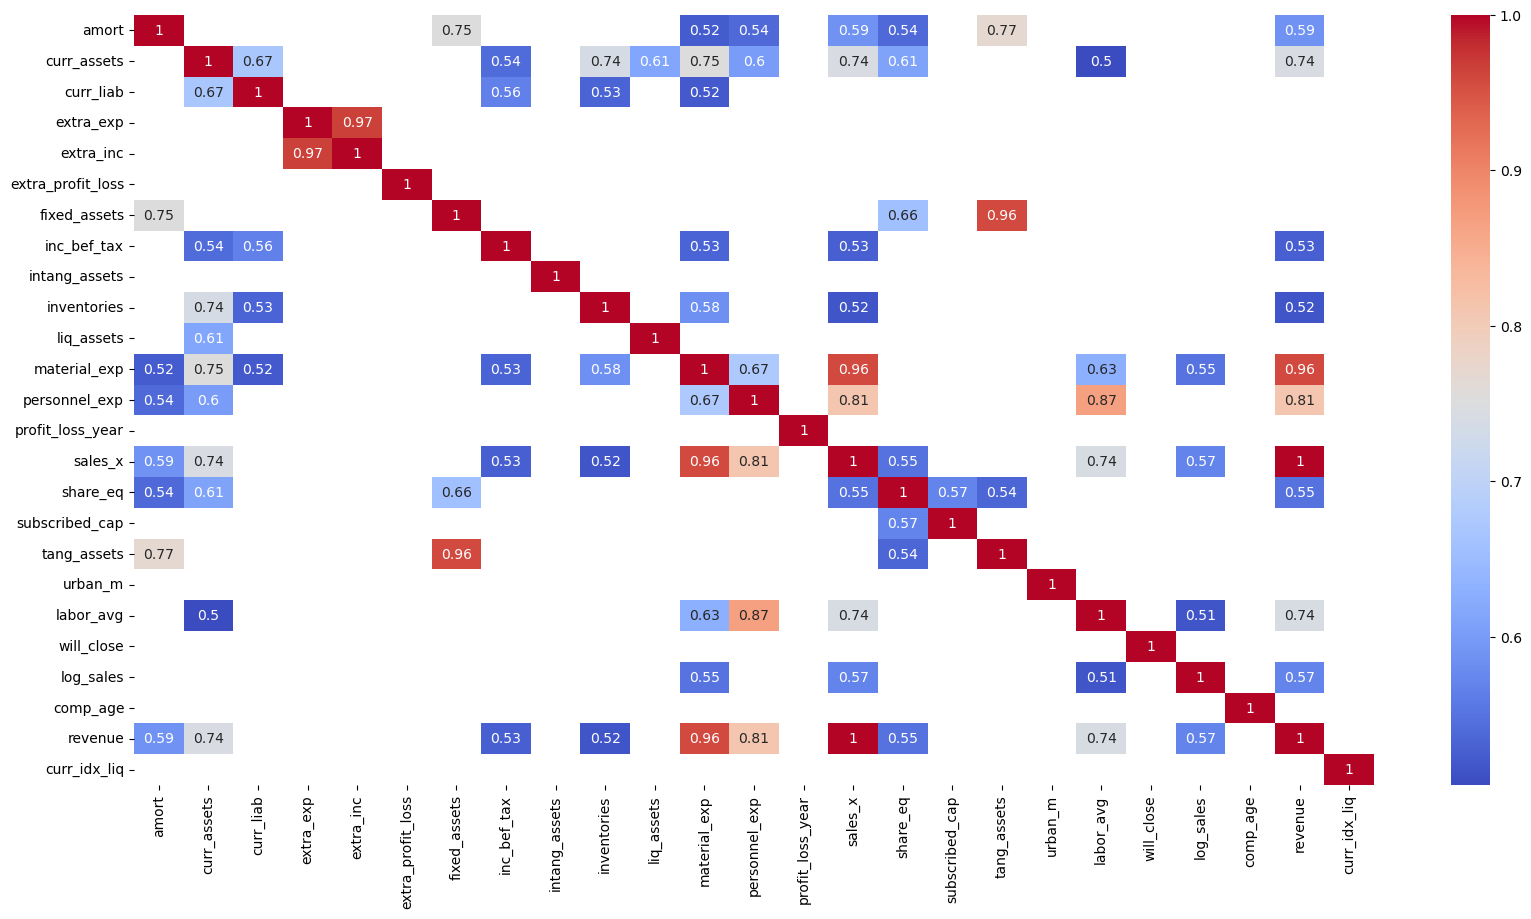

In [60]:
# fazendo heatmap para variáveis com correlação maior que 0.5:
plt.figure(figsize=(20,10))
sns.heatmap(df3.corr()[df3.corr() > 0.5], annot=True, cmap='coolwarm')
plt.show()

## 5.2. Analise Bivariada

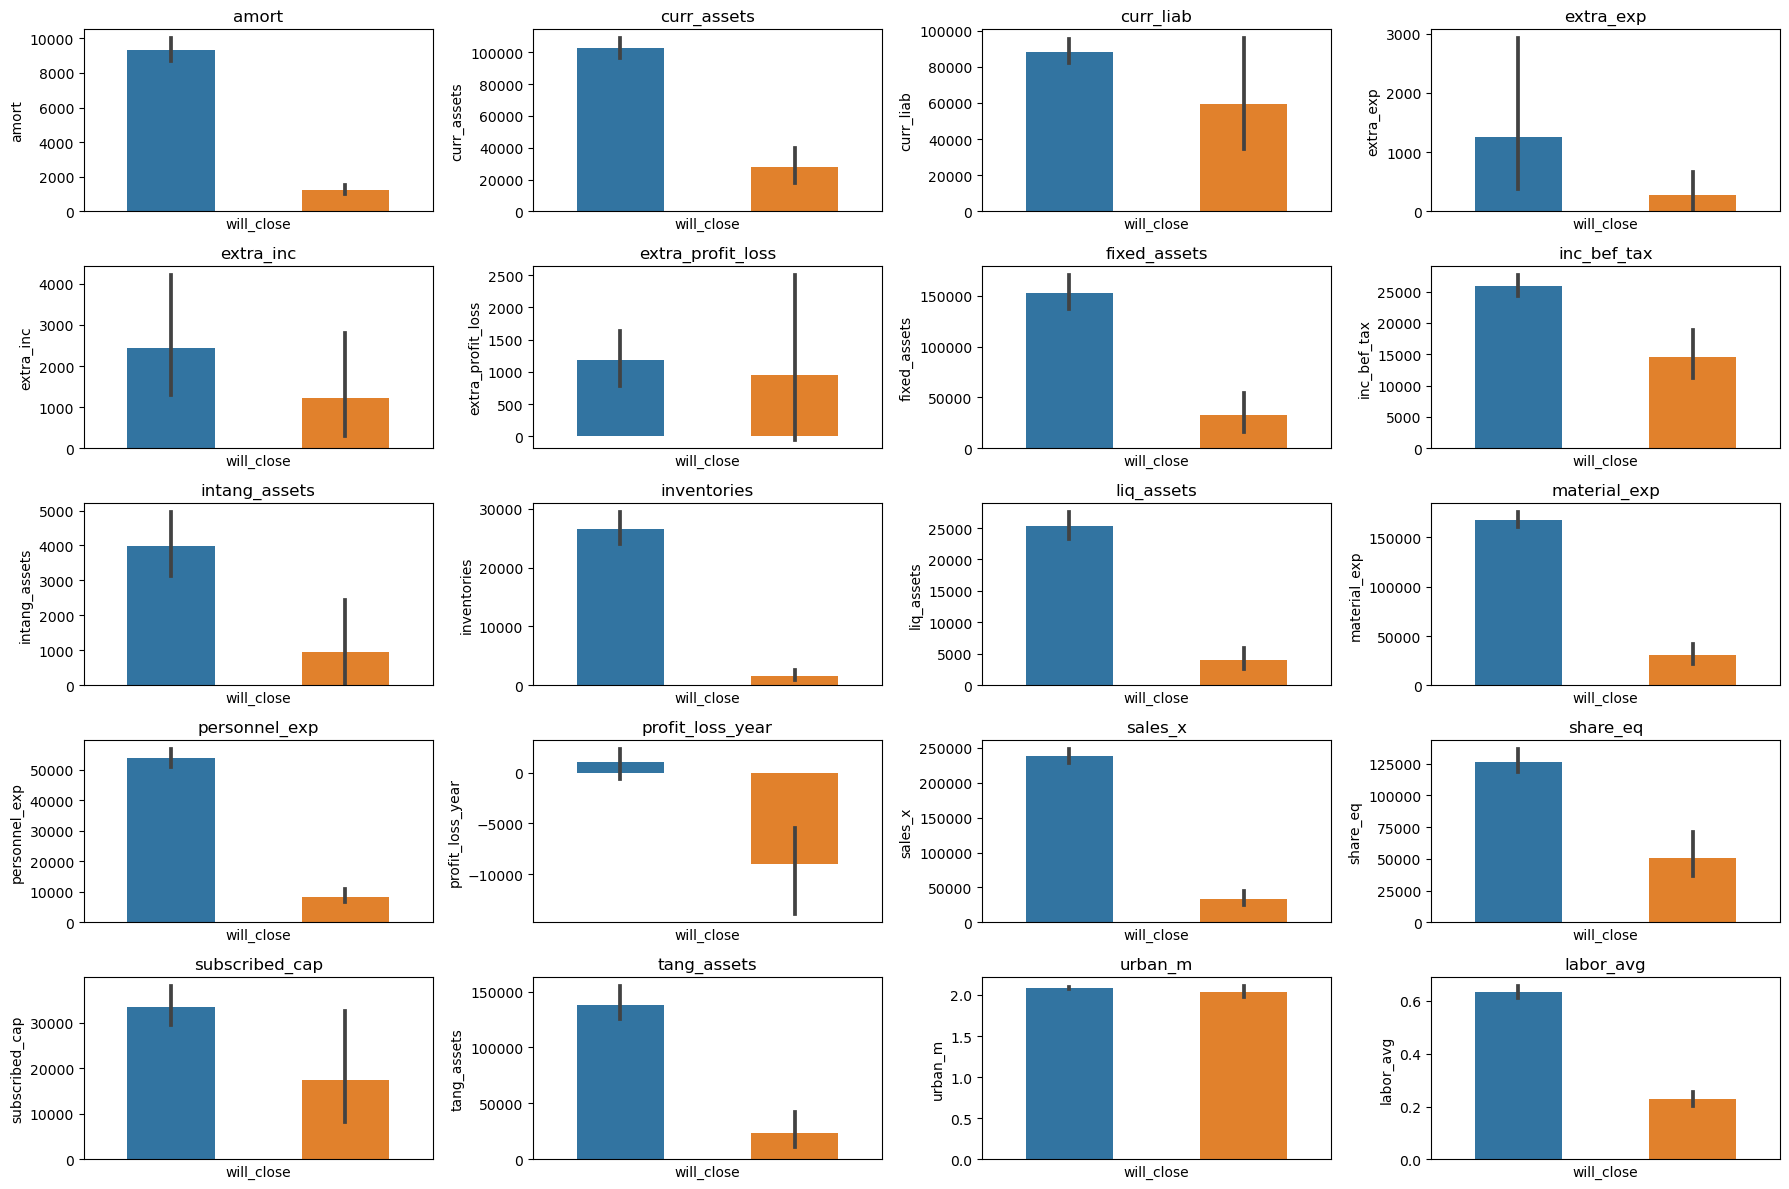

c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


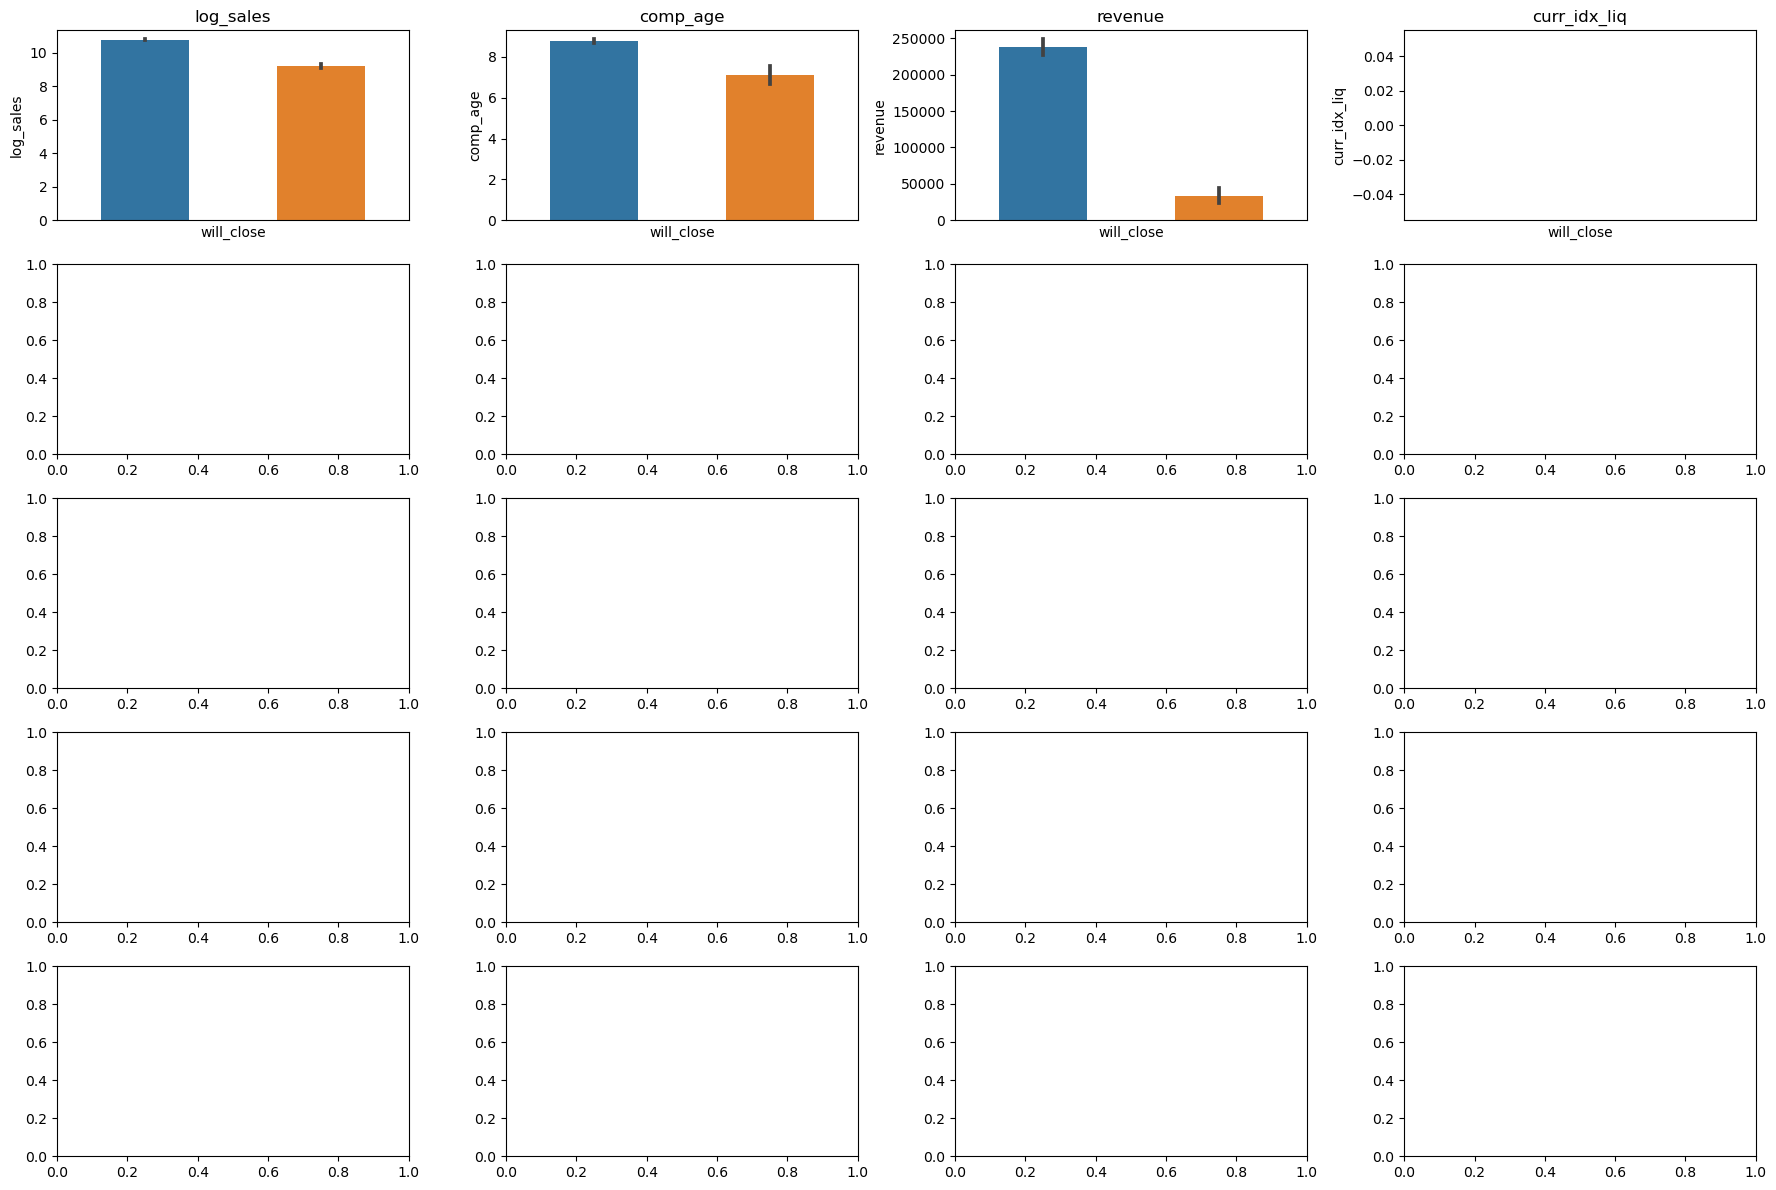

In [61]:
# fazendo barplot das variáveis numéricas:
colunas = var_num.columns

# Configurações para a disposição dos subplots
num_linhas = 5
num_colunas = 4

# Calcula o número total de figuras necessárias
num_total_figuras = (len(colunas) // (num_linhas * num_colunas)) + 1

# Tamanho da figura
tamanho_figura = (18, 12)

# Loop para criar cada figura com os boxplots
for figura_num in range(num_total_figuras):
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=tamanho_figura)

    # Colunas para esta figura
    inicio_coluna = figura_num * num_linhas * num_colunas
    fim_coluna = (figura_num + 1) * num_linhas * num_colunas
    colunas_figura = colunas[inicio_coluna:fim_coluna]

    # Iterar pelas colunas e criar os boxplots para esta figura
    for i, coluna in enumerate(colunas_figura):
        linha = i // num_colunas
        col = i % num_colunas
        sns.barplot(x=df2['will_close'], y=var_num[coluna], ax=axs[linha, col], width=0.5)
        axs[linha, col].set_title(coluna)
        axs[linha, col].set_xticks([])  # Remove os rótulos do eixo x

    # Ajustar o layout
    plt.tight_layout()

    # Exibir a figura
    plt.show()

# PASSO 06 - DATA PREPARATION

## 6.1. Normalizacao

"amort": A amortização representa a redução do principal de uma dívida, e normalmente é positiva.

"curr_assets" (ativos circulantes): Esses ativos são recursos disponíveis no curto prazo, como caixa, contas a receber e estoque. Eles devem ser positivos em condições normais.

"curr_liab" (passivos circulantes): Esses são passivos que a empresa espera liquidar no curto prazo, como contas a pagar e dívidas de curto prazo. Eles também devem ser positivos em condições normais.

"extra_exp" e "extra_inc" (despesas e receitas extraordinárias): Essas variáveis podem representar valores atípicos nos resultados financeiros da empresa, mas, em geral, são tratadas como valores positivos ou zero.

"extra_profit_loss" (lucro ou prejuízo extraordinário): Representa resultados financeiros excepcionais e, portanto, pode ser positivo ou negativo, dependendo da natureza desses eventos.

"fixed_assets" (ativos fixos): Representa os ativos de longo prazo da empresa, como equipamentos e propriedades. Eles geralmente são positivos.

"inc_bef_tax" (lucro antes de impostos): Deve ser positivo, representando o lucro da empresa antes dos impostos.

"intang_assets" (ativos intangíveis): São ativos como patentes, marcas registradas e goodwill. Normalmente, são positivos.

"inventories" (estoque): Representa os produtos ou mercadorias que a empresa possui. Deve ser positivo.

"liq_assets" (ativos líquidos): Representa os ativos disponíveis para pagamento de dívidas de curto prazo. Deve ser positivo.

"material_exp" e "personnel_exp" (despesas de materiais e pessoal): Essas variáveis representam os gastos da empresa com materiais e pessoal. Em condições normais, são positivas.

"profit_loss_year" (lucro ou prejuízo no ano): Deve ser positivo quando a empresa gera lucro e negativo quando gera prejuízo.

"sales_x" (vendas): Representa a receita de vendas e deve ser positiva.

"share_eq" (patrimônio líquido): Representa o valor contábil dos ativos menos os passivos. Normalmente, é positivo.

"subscribed_cap" (capital subscrito): Representa o capital que os acionistas se comprometeram a investir na empresa. Geralmente, é positivo.

"tang_assets" (ativos tangíveis): São ativos físicos, como propriedades e equipamentos. Normalmente, são positivos.

"urban_m" (indicador urbano): A natureza dessa variável depende do contexto, mas geralmente não deve ser negativa.

"labor_avg" (média de mão de obra): Representa a média de mão de obra. Deve ser positiva.



In [63]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
amort,21595.0,9091.481946,4.930977e+04,0.000000e+00,118.518517,862.962952,3911.111084,3.570863e+06
curr_assets,21625.0,100258.687360,4.619654e+05,0.000000e+00,3292.592529,11296.295898,39166.667969,2.066350e+07
curr_liab,21625.0,87491.261187,5.120497e+05,0.000000e+00,3574.073975,14133.333008,46766.667969,4.186429e+07
extra_exp,21635.0,1228.060438,1.161053e+05,0.000000e+00,0.000000,0.000000,0.000000,1.704172e+07
extra_inc,21635.0,2404.308753,1.203972e+05,0.000000e+00,0.000000,0.000000,0.000000,1.709232e+07
extra_profit_loss,21635.0,1173.180740,3.098886e+04,-2.888889e+05,0.000000,0.000000,0.000000,3.253704e+06
fixed_assets,21625.0,149403.392770,1.161742e+06,0.000000e+00,85.185188,4366.666504,37496.296875,1.036673e+08
inc_bef_tax,21635.0,25469.744544,1.245570e+05,0.000000e+00,1453.703674,5196.296387,15237.037109,1.091879e+07
intang_assets,21625.0,3897.037972,6.690205e+04,0.000000e+00,0.000000,0.000000,0.000000,5.630704e+06
inventories,21625.0,25830.944005,2.025387e+05,0.000000e+00,0.000000,1103.703735,6933.333496,1.725857e+07


## 6.1.1 Valores negativos

Alterando para valor absoluto as variáveis que não fazem sentido terem valores negativos

In [64]:
df4 = df3.copy()

colunas_abs = ["amort", "curr_assets", "curr_liab", "extra_exp", "extra_inc", "fixed_assets", "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp", "sales_x", "share_eq", "subscribed_cap", "tang_assets", "urban_m", "labor_avg", "comp_age"]

for coluna in colunas_abs:
    df4[coluna] = df4[coluna].abs()
    
# verificando se os valores foram transformados:
df4.describe().T



,count,mean,std,min,25%,50%,75%,max
amort,21595.0,9091.481946,4.930977e+04,0.000000e+00,118.518517,862.962952,3911.111084,3.570863e+06
curr_assets,21625.0,100258.687360,4.619654e+05,0.000000e+00,3292.592529,11296.295898,39166.667969,2.066350e+07
curr_liab,21625.0,87491.261187,5.120497e+05,0.000000e+00,3574.073975,14133.333008,46766.667969,4.186429e+07
extra_exp,21635.0,1228.060438,1.161053e+05,0.000000e+00,0.000000,0.000000,0.000000,1.704172e+07
extra_inc,21635.0,2404.308753,1.203972e+05,0.000000e+00,0.000000,0.000000,0.000000,1.709232e+07
extra_profit_loss,21635.0,1173.180740,3.098886e+04,-2.888889e+05,0.000000,0.000000,0.000000,3.253704e+06
fixed_assets,21625.0,149403.392770,1.161742e+06,0.000000e+00,85.185188,4366.666504,37496.296875,1.036673e+08
inc_bef_tax,21635.0,25469.744544,1.245570e+05,0.000000e+00,1453.703674,5196.296387,15237.037109,1.091879e+07
intang_assets,21625.0,3897.037972,6.690205e+04,0.000000e+00,0.000000,0.000000,0.000000,5.630704e+06
inventories,21625.0,25830.944005,2.025387e+05,0.000000e+00,0.000000,1103.703735,6933.333496,1.725857e+07


In [76]:
# calculando a assimetria das variáveis numéricas e guardando valores com skew acima de 5 para avaliar a distribuição para fazer transformação em log:
df4.skew()


C:\Users\tiago\AppData\Local\Temp\ipykernel_58444\1087798978.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4.skew()


comp_id                0.621011
amort                 27.074115
curr_assets           15.130649
curr_liab             46.647612
extra_exp            146.161027
extra_inc            133.454801
extra_profit_loss     70.332273
fixed_assets          43.205878
inc_bef_tax           38.316167
intang_assets         46.658824
inventories           38.871308
liq_assets            20.431963
material_exp           8.162483
personnel_exp         12.099127
profit_loss_year     -40.429988
sales_x                7.330876
share_eq              19.627066
subscribed_cap        34.502265
tang_assets           50.058783
urban_m               -0.154441
labor_avg              9.245367
will_close             5.510992
log_sales              0.302102
comp_age               0.513378
revenue                7.330876
curr_idx_liq                NaN
dtype: float64

In [71]:
# verificando quantos valores estão em acima do percentil 75%, 85 e 95%  em cada variável numérica:
for coluna in var_num.columns:
    print(coluna)

    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.25)].count())
    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.50)].count())
    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.75)].count())
    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.85)].count())
    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.95)].count())
    print('')

amort
16174
10786
5397
3240
1080

curr_assets
16214
10812
5405
3244
1082

curr_liab
16218
10812
5406
3244
1082

extra_exp
1681
1681
1681
1681
1059

extra_inc
1745
1745
1745
1745
1082

extra_profit_loss
1519
1519
1519
1519
1081

fixed_assets
16212
10810
5406
3244
1082

inc_bef_tax
16226
10817
5408
3246
1082

intang_assets
3170
3170
3170
3170
1082

inventories
13840
10812
5406
3244
1082

liq_assets
16208
10810
5406
3244
1082

material_exp
16196
10796
5399
3240
1080

personnel_exp
16194
10797
5399
3240
1080

profit_loss_year
16218
10792
5405
3244
1082

sales_x
16226
10817
5409
3246
1082

share_eq
16218
10811
5406
3244
1082

subscribed_cap
10731
10731
3351
3228
1073

tang_assets
16207
10812
5406
3244
1082

urban_m
14705
8684
0
0
0

labor_avg
13778
9131
4599
2775
925

log_sales
16226
10817
5409
3246
1082

comp_age
15732
10644
4791
2688
779

revenue
16226
10817
5409
3246
1082

curr_idx_liq
16212
10808
5404
3243
1081



In [73]:
#verificando porcentagem de valores com percentil 75%, 85% e 95% em cada variável numérica:

for coluna in var_num.columns:
    print(coluna)
    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.75)].count()/df4.shape[0])
    print('')


amort
0.2494568985440259

curr_assets
0.24982666974809337

curr_liab
0.2498728911486018

extra_exp
0.07769817425467991

extra_inc
0.08065634388721979

extra_profit_loss
0.07021030737231339

fixed_assets
0.2498728911486018

inc_bef_tax
0.24996533394961867

intang_assets
0.14652183961174023

inventories
0.2498728911486018

liq_assets
0.2498728911486018

material_exp
0.24954934134504275

personnel_exp
0.24954934134504275

profit_loss_year
0.24982666974809337

sales_x
0.2500115553501271

share_eq
0.2498728911486018

subscribed_cap
0.15488791310376704

tang_assets
0.2498728911486018

urban_m
0.0

labor_avg
0.21257222093829442

log_sales
0.2500115553501271

comp_age
0.22144672983591404

revenue
0.2500115553501271

curr_idx_liq
0.24978044834758492



In [74]:
#verificando quantidade de outliers em cada variável numérica:

for coluna in var_num.columns:
    print(coluna)
    print(df4[coluna][df4[coluna] > df4[coluna].quantile(0.75)].count())
    print('')

amort
5397

curr_assets
5405

curr_liab
5406

extra_exp
1681

extra_inc
1745

extra_profit_loss
1519

fixed_assets
5406

inc_bef_tax
5408

intang_assets
3170

inventories
5406

liq_assets
5406

material_exp
5399

personnel_exp
5399

profit_loss_year
5405

sales_x
5409

share_eq
5406

subscribed_cap
3351

tang_assets
5406

urban_m
0

labor_avg
4599

log_sales
5409

comp_age
4791

revenue
5409

curr_idx_liq
5404



In [78]:
df5 = df4.copy()
# transformando variáveis extra_exp, extra_inc e extra_profit_loss em log:
df5['extra_exp'] = np.log(df4['extra_exp'])
df5['extra_inc'] = np.log(df4['extra_inc'])
df5['extra_profit_loss'] = np.log(df4['extra_profit_loss'])


c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\tiago\AppData\Local\Temp\ipykernel_58444\3250614697.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df5.corr()[df5.corr() > 0.5], annot=True, cmap='coolwarm')


<Axes: >

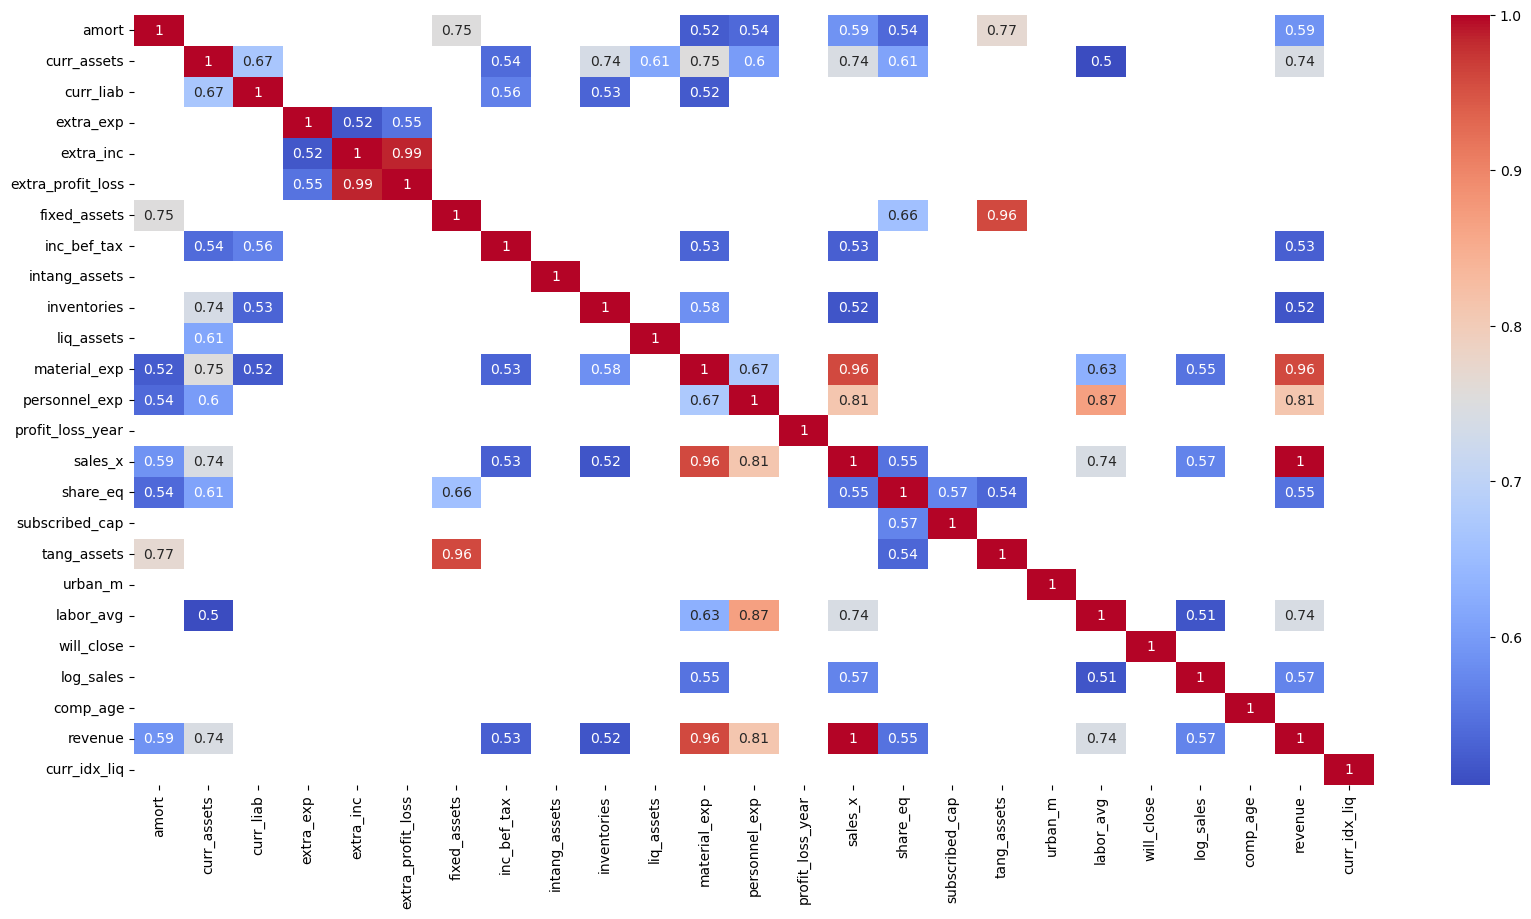

In [83]:
#fazendo gráfico de correlação das variáveis numéricas:
plt.figure(figsize=(20,10))
sns.heatmap(df5.corr()[df5.corr() > 0.5], annot=True, cmap='coolwarm')

# PASSO 07 - SELEÇÃO DE VARIÁVEIS

## 7.1. Split do Dataframe entre Treino e Teste

# PASSO 08 - MODELAGEM DE MACHINE LEARNING


## 8.1. Modelo nulo - Média

## 8.2. Modelo de Regressão Linear

## 8.3. Modelo de Regressão Linear Regularizada - LASSO

## 8.4. Floresta Aleatória

## 8.5. Comparando performance